# The Linear Regression Model of Time Series
- An AR model using the same parameters(training size, testing size, number of lags) as the LSTM and the combined model
- Differenced and Rescaled data

In [1]:
import pandas as pd
import numpy as np
import random
from statsmodels.tsa.stattools import pacf
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
df = pd.read_csv("JointData.csv", index_col = False)
df = df[["date","cases"]]  # use only daily increment of cases to forcast
df.reset_index(drop=True, inplace=True)
df.head()

,date,cases
0,2020-07-27,207.0
1,2020-07-28,128.0
2,2020-07-29,126.0
3,2020-07-30,105.0
4,2020-07-31,112.0


## Autoregressive Model
- Use only past cases
- Remove day of week effect by replace $y_t$ with an average of 7 previous days(inclusive)
    - Each value is an average of data from all 7 different weekdays, thud day of week effect removed

In [4]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# starting from the 7th day:
cases_ave = []
for i in range(6,len(df)):
    # remove day of week effect
    temp = np.mean(df.cases.iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
    cases_ave.append(temp)

df = df.iloc[6:].reset_index(drop = True)  # start on day 7, update index
df['case'] = cases_ave

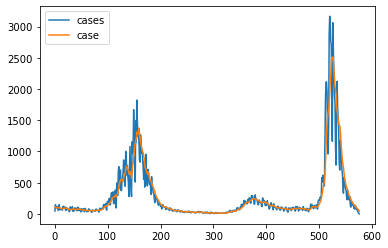

In [5]:
df.plot()
plt.show()  # cases- original data, case- smoothed version w/o day of week effect

In [6]:
df.head()

,date,cases,case
0,2020-08-02,46.0,114.142857
1,2020-08-03,147.0,105.571429
2,2020-08-04,91.0,100.285714
3,2020-08-05,114.0,98.571429
4,2020-08-06,116.0,100.142857


In [7]:
# work with time series:
df1 = df[["date", "case"]]
# df1["date"] = pd.to_datetime(df1["date"])  # convert to datatime
df1.set_index("date", inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577 entries, 2020-08-02 to 2022-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   case    577 non-null    float64
dtypes: float64(1)
memory usage: 9.0+ KB


In [8]:
df1 = df1.to_dict()['case']  # convert to dict in order to convert to series

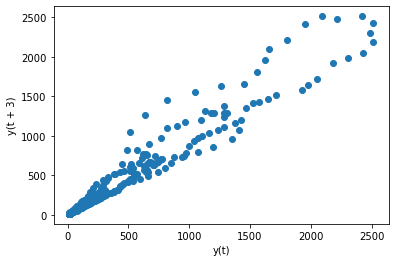

In [9]:
# check the lag
s = pd.Series(df1)
pd.plotting.lag_plot(s, lag = 3)  # larger lag --> weaker correlation
plt.show()

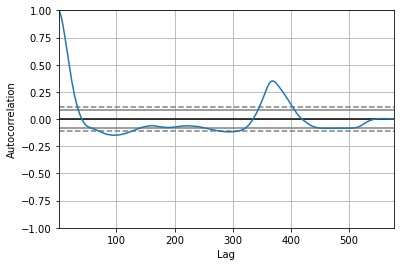

In [10]:
# autocorrelation plot
pd.plotting.autocorrelation_plot(s)
plt.show()

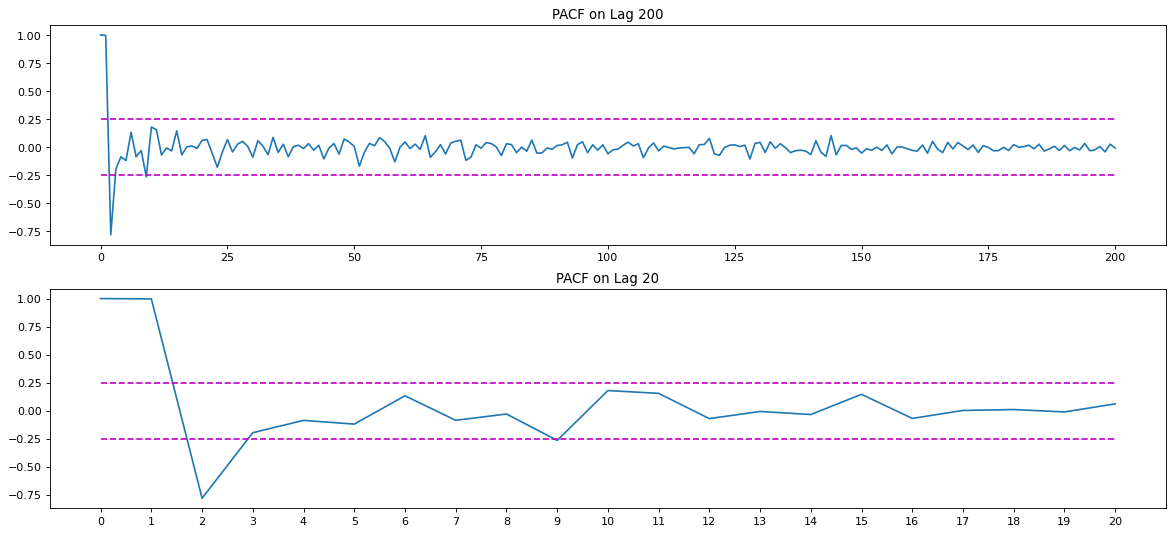

In [11]:
# calculate pacf of smoothed case
pacf_value = pacf(df.case,nlags=200,method="ols",alpha=None)
# caculate 95% confidence interval
up = np.mean(pacf_value) + 1.96 * np.std(pacf_value)
lo = np.mean(pacf_value) - 1.96 * np.std(pacf_value)
# plot
figure(figsize=(18, 8), dpi=80)
plt.subplot(2, 1, 1)
plt.plot(pacf_value)
plt.title("PACF on Lag 200")
plt.plot(range(len(pacf_value)),np.repeat(up,len(pacf_value)), 'm--')
plt.plot(range(len(pacf_value)),np.repeat(lo,len(pacf_value)), 'm--')

plt.subplot(2, 1, 2)
plt.plot(pacf_value[0:21])
plt.title("PACF on Lag 20")
plt.plot(range(0,21),np.repeat(up,len(pacf_value[0:21])), 'm--')
plt.plot(range(0,21),np.repeat(lo,len(pacf_value[0:21])), 'm--')
plt.xticks(range(0,21))
plt.show()

## Differencing

In [12]:
# create a differenced series
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)  # fit on data, and transform
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # split into train and test sets
    # rescale training data, no need to rescale testing data
    train, test = scaled_values[-(test_size+train_size):-test_size], raw_values[-test_size:]
    return scaler, train, test

Check PACF again after Differencing

In [13]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
train_size = 63  # train set size
test_size = 18 # test set size
# prepare data
scaler, train, test = prepare_data(s, test_size, n_lag, n_seq)

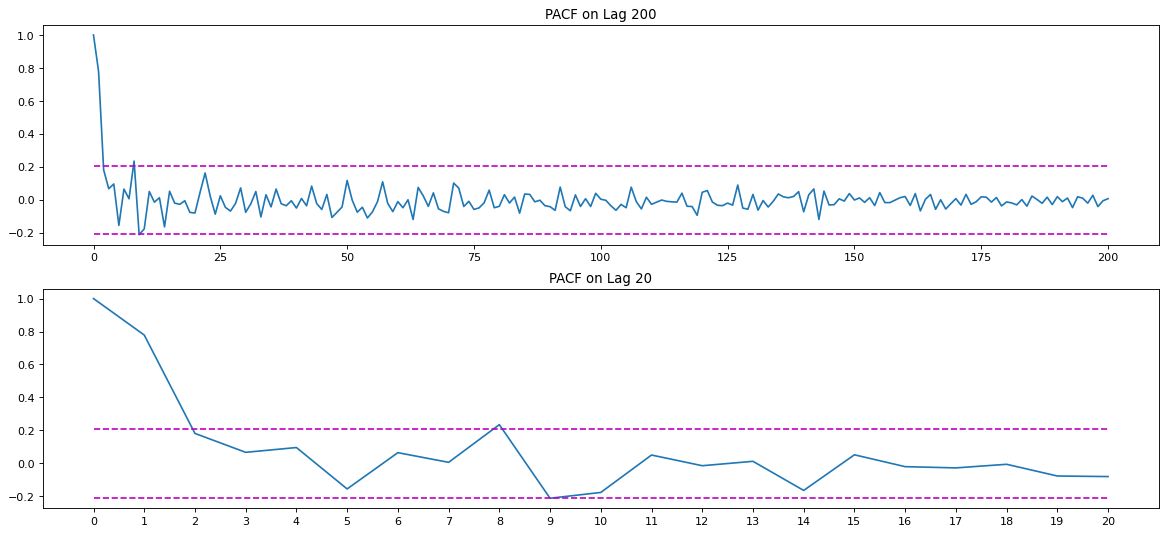

In [14]:
# Recheck the PACF Plot
# calculate pacf of smoothed case after differencing, I = 1
diff = difference(s.values)
pacf_value = pacf(diff,nlags=200,method="ols",alpha=None)
# caculate 95% confidence interval
up = np.mean(pacf_value) + 1.96 * np.std(pacf_value)
lo = np.mean(pacf_value) - 1.96 * np.std(pacf_value)
# plot
figure(figsize=(18, 8), dpi=80)
plt.subplot(2, 1, 1)
plt.plot(pacf_value)
plt.title("PACF on Lag 200")
plt.plot(range(len(pacf_value)),np.repeat(up,len(pacf_value)), 'm--')
plt.plot(range(len(pacf_value)),np.repeat(lo,len(pacf_value)), 'm--')

plt.subplot(2, 1, 2)
plt.plot(pacf_value[0:21])
plt.title("PACF on Lag 20")
plt.plot(range(0,21),np.repeat(up,len(pacf_value[0:21])), 'm--')
plt.plot(range(0,21),np.repeat(lo,len(pacf_value[0:21])), 'm--')
plt.xticks(range(0,21))
plt.show()

## Reversing Method for Differencing

In [15]:
# invert differenced forecast
# transform back to original scale
def inv_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
# inverse data transform on forecasts
def inv_transform(series, forecasts, scaler, n_test):
    inverted = list()
    forecast = forecasts.reshape(1, len(forecasts))
    # invert scaling
    inv_scale = scaler.inverse_transform(forecast)
    inv_scale = inv_scale[0]
    # invert differencing
    index = len(series) - n_test - 1
    last_ob = series.values[index]
    # inv_diff = inv_difference(last_ob, inv_scale)
    inv_diff = inv_difference(last_ob, inv_scale)
    # store as np array, reshape for future comparison
    inverted.append(inv_diff)
    inverted = np.asarray(inverted)
    inverted = inverted.reshape(inverted.shape[1],1)  # (n_size-1, 1)
    return inverted

## Training Model

### AutoRegression
- assume observations from previous time steps are useful to predict values at latter time steps
    - true for Time Series
- choose a proper lag
    - use lag as variable
    - if all lag variables show no correlation with output, then the time series problem could be not predictable
    - Use the same lag number for AR, LSTM, and combined, for comparison

$$y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$$
where $p$ is the lag number

In [16]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(train, lags=n_lag)
model = model.fit()
# n_lag = 7 yields 8 parameters, which make sense since there exists a constant term
print('Coefficients: {}'.format(model.params))

Coefficients: [-0.00697673  0.78434639  0.06385952  0.1143236  -0.13341888 -0.08368909
  0.09091613  0.05014761]


In [17]:
# make predictions
pred = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# inverse transform forecasts and test
pred = inv_transform(s, pred, scaler, test_size+1)
rmse = np.sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)
print("Test RMSE: {}".format(rmse))

Test RMSE: 50.5021361853772


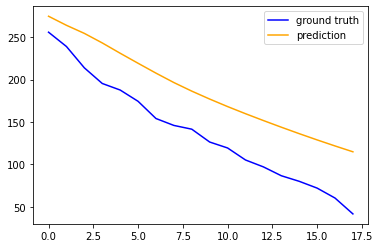

In [18]:
plt.plot(test, color = 'blue', label = "ground truth")
plt.plot(pred, color = 'orange', label = "prediction")
plt.legend()
plt.show()

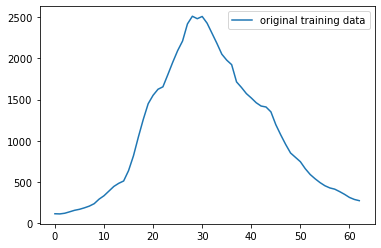

In [19]:
original_train = s[-(test_size+train_size):-test_size]
x = range(0,len(original_train))
plt.plot(x,original_train, label = "original training data")
plt.legend()
plt.show()

Notice: absence of a periodic trend. As a result, including more data does not always give us a better result
- from the plot of training cases above, if we use the 63 days before testing dates as training data, the trend cancels out, and the model yields a flat line.

But how do we know the best size of training set, under the absence of a periodic trend?
- Let the machine decides
    - Now explore: LSTM model